<a href="https://colab.research.google.com/github/Ry02024/CrimeForecast2014ByBQ/blob/main/notebooks/CrimeForecast2024ByBQ_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#データサイエンス的流れ

##データソースに接続

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
from google.cloud import bigquery

# Create a client to access the data
project_id = 'bigqueryry0'
client = bigquery.Client(project=project_id)

##データの取得

##データ分析

In [22]:
# Query to fetch data for training
query_train = """
SELECT
  FORMAT_TIMESTAMP('%Y-%m', TIMESTAMP(timestamp)) AS year_month,
  primary_type,
  COUNT(*) AS crime_count
FROM
  `bigqueryry0.austin_crime_data.crime`
WHERE
  TIMESTAMP(timestamp) BETWEEN '2014-01-01' AND '2014-06-30'
GROUP BY
  year_month, primary_type
ORDER BY
  year_month
"""
df_train = client.query(query_train).to_dataframe()

# Query to fetch data for prediction
query_test = """
SELECT
  FORMAT_TIMESTAMP('%Y-%m', TIMESTAMP(timestamp)) AS year_month,
  primary_type,
  COUNT(*) AS crime_count
FROM
  `bigqueryry0.austin_crime_data.crime`
WHERE
  TIMESTAMP(timestamp) BETWEEN '2014-07-01' AND '2014-12-31'
GROUP BY
  year_month, primary_type
ORDER BY
  year_month
"""
df_test = client.query(query_test).to_dataframe()

In [23]:
df_train

,year_month,primary_type,crime_count
0,2014-01,Aggravated Assault,162
1,2014-01,Theft: BOV,858
2,2014-01,Theft: All Other Larceny,1120
3,2014-01,Rape,60
4,2014-01,Auto Theft,176
...,...,...,...
76,2014-06,Theft: Coin Op Machine,9
77,2014-06,Robbery,73
78,2014-06,Theft: Auto Parts,22
79,2014-06,Homicide: Murder & Nonnegligent Manslaughter,2


##可視化

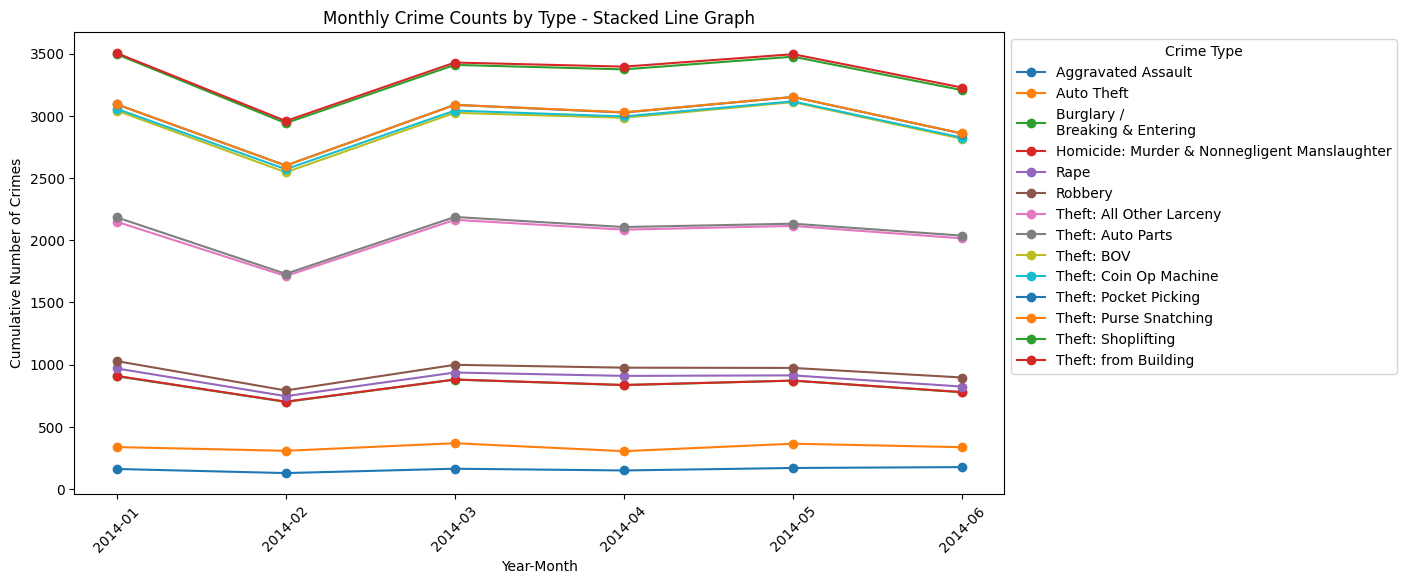

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it has been preprocessed correctly
# Pivot your data for plotting
pivot_df = df_train.pivot_table(index='year_month', columns='primary_type', values='crime_count', fill_value=0)

# Cumulative sum for stacking
cumulative = pivot_df.cumsum(axis=1)

# Plot each crime type
fig, ax = plt.subplots(figsize=(12, 6))
for column in cumulative.columns:
    ax.plot(cumulative.index, cumulative[column], label=column, marker='o')

ax.set_title('Monthly Crime Counts by Type - Stacked Line Graph')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Cumulative Number of Crimes')
plt.xticks(rotation=45)
plt.legend(title='Crime Type', loc='upper left', bbox_to_anchor=(1,1))  # This moves the legend outside
plt.show()

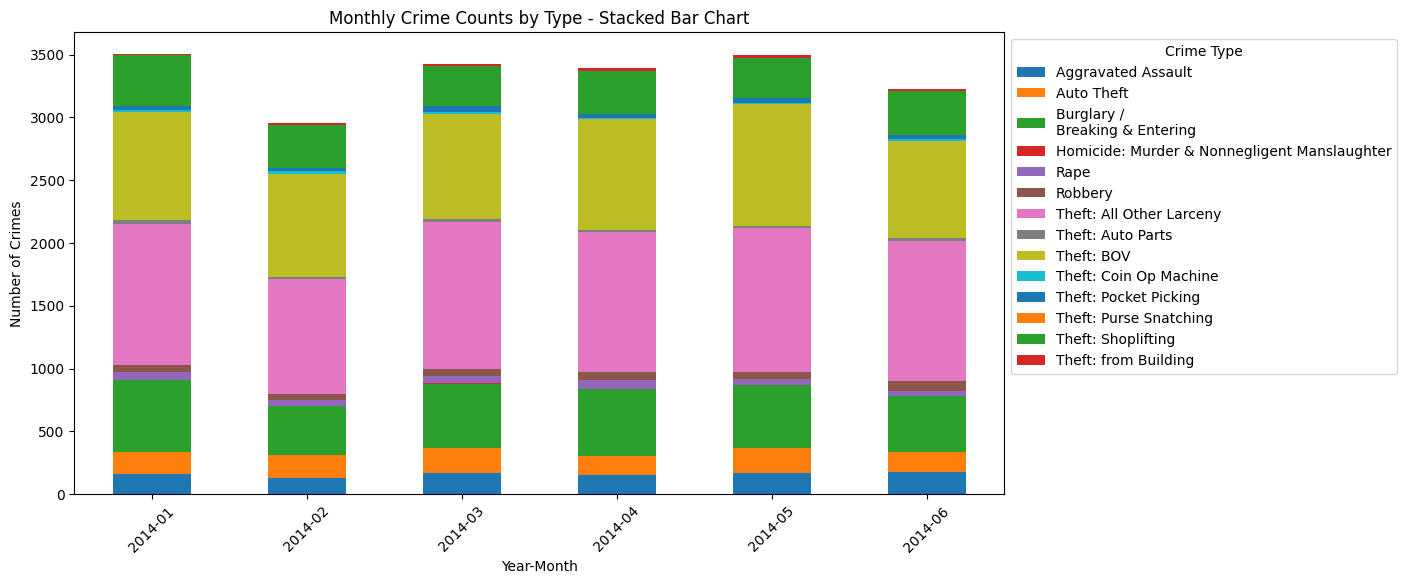

In [25]:
# Again, using the pivot_df from the previous example
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Monthly Crime Counts by Type - Stacked Bar Chart')
plt.xlabel('Year-Month')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.legend(title='Crime Type', loc='upper left', bbox_to_anchor=(1,1))  # This moves the legend outside
plt.show()

##予測モデルの作成

In [26]:
# Define high crime for training data
median_train = df_train['crime_count'].median()
df_train['high_crime'] = np.where(df_train['crime_count'] > median_train, 1, 0)

# Define high crime for testing data
median_test = df_test['crime_count'].median()
df_test['high_crime'] = np.where(df_test['crime_count'] > median_test, 1, 0)

# Prepare features
df_train['month'] = pd.to_datetime(df_train['year_month']).dt.month
df_test['month'] = pd.to_datetime(df_test['year_month']).dt.month

X_train = df_train[['month']]
y_train = df_train['high_crime']
X_test = df_test[['month']]
y_test = df_test['high_crime']

In [27]:
# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions and evaluations on the test set
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.49      1.00      0.66        39

    accuracy                           0.49        80
   macro avg       0.24      0.50      0.33        80
weighted avg       0.24      0.49      0.32        80



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])